In [28]:
import numpy as np

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import seml.database as db_utils
from pathlib import Path

import torch

from itertools import product

from statsmodels.stats.proportion import proportion_confint

import pandas as pd

import os

import sys
sys.path.append('..')
from utils import load_results

In [29]:
collection = 'invariance_eval_inverse_multiple_inner_cross'


jk_config = {
    'username': 'schuchaj',
    'password': 'coolpassword',
    'host': 'hostofyourdatabase',
    'port': 27017,
    'db_name': 'nameofyourdatabase'
}

col = db_utils.get_collection(collection, mongodb_config=jk_config)

In [30]:
def get_experiments(col, restrictions={}):
    
    restrictions['status'] = 'COMPLETED'

    if col.count_documents(restrictions) == 0:
        raise ValueError('No matches!')

    exps = col.find(restrictions)
    
    return exps

In [31]:
def get_certificates(raw_results_file):
        raw_results = torch.load(raw_results_file)

        assert len(raw_results.keys()) == 2

        cert_dict = list(raw_results.values())[1]

        ret_dict = {}
        
        ret_dict['pmin_cohen'] = cert_dict['inverse_cohen']
        pmin_ours = cert_dict['inverse_ours']
        valid_params_mask = cert_dict['valid_params_mask']
        ret_dict['inner_vals'] = cert_dict['inner_vals']
        ret_dict['cross_vals'] = cert_dict['cross_vals']
        
        if 'inverse_rotation_only' in cert_dict:
            rot_only_dict = cert_dict['inverse_rotation_only']

            closest_inner_idx = np.abs(ret_dict['inner_vals'] - rot_only_dict['inner']).argmin()
            ret_dict['rotation_inner_idx'] = closest_inner_idx
            
            for i, cross in enumerate([rot_only_dict['cross_1'], rot_only_dict['cross_2']]):
                closest_cross_idx = np.abs(ret_dict['cross_vals'] - cross).argmin()

                pmin_ours[closest_inner_idx, closest_cross_idx] = rot_only_dict[f'cert_{i+1}']

                ret_dict[f'rotation_cross_idx_{i+1}'] = closest_cross_idx

                valid_params_mask[closest_inner_idx, closest_cross_idx] = True

        ret_dict['pmin_ours'] = pmin_ours
        ret_dict['valid_params_mask'] = valid_params_mask
                
        return ret_dict

In [32]:
def generate_exp_result_dict(exp):

    result_dict = {}
    
    result_dict['std'] = exp['config']['sigma']
    result_dict['norm_clean'] = exp['config']['norms_clean_params']['values'][0]
    result_dict['norm_delta'] = exp['config']['norms_delta_params']['values'][0]

    result_dict['raw_results_file'] = exp['result']['save_file']

    cert_dict = get_certificates(result_dict['raw_results_file']) 

    result_dict.update(
        cert_dict
    )

    return result_dict

In [34]:
experiments = get_experiments(col, restrictions={
    'config.n_samples_clean': 100000,
    'config.n_samples_pert': 100000
})
results = load_results(
            generate_exp_result_dict,
            experiments,
            results_file='/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/raw_data',
            #overwrite=True
            )
        
results = results.replace(np.nan, None)

In [35]:
def plot_colormap(ax, norm_param, pmin_difference, valid_params_mask, vmin=None, vmax=None, drop_ylabel=False,
                  varying_norm_clean=True, rotation_inner_idx=None, rotation_cross_idx_1=None, rotation_cross_idx_2=None,
                  highlight_rotation=True):
    
    pmin_difference = pmin_difference.copy()
    pmin_difference[~valid_params_mask] = np.nan

    cmap = sns.color_palette('rocket', as_cmap=True).copy()
    cmap.set_bad('white')
    
    ax.grid(False)
    im = ax.imshow(pmin_difference.T,
              cmap=cmap,
              vmin=vmin,
              vmax=vmax,
              origin='lower')

    if (highlight_rotation) and (rotation_inner_idx is not None):
        rotation_inner_idx = int(rotation_inner_idx)
        rotation_cross_idx_1 = int(rotation_cross_idx_1)
        rotation_cross_idx_2 = int(rotation_cross_idx_2)
        
        ax.scatter([rotation_inner_idx], [rotation_cross_idx_1], marker='x', color='C0')

        ax.scatter([rotation_inner_idx], [rotation_cross_idx_2], marker='x', color='C0')
    
    ax.set_xticks([0, 50, 100])
    ax.set_xticklabels([-1, 0, 1])

    ax.set_yticks([0, 50, 100])
    ax.set_yticklabels([-1, 0, 1])

    ax.set_ylim(0,100)

    ax.grid(False)

    ax.set_xlabel(r'$\tilde{\epsilon}_1$')
    if not drop_ylabel:
        ax.set_ylabel(r'$\tilde{\epsilon}_2$')

    if varying_norm_clean:
        ax.set_title(f'$||X||$={norm_param}')
    else:
        ax.set_title(f'$||\Delta||$={norm_param}')

    return im

In [36]:
def calc_pmin_difference(pmin_cohen, pmin_ours, valid_param_mask):
    diff = np.maximum(0, pmin_cohen - pmin_ours)
    diff[~valid_param_mask] = 0

    return diff

In [37]:
def plot_multiple_colormaps(results, std, norms_clean: list, deltas: list,
                            shared_colorbar=True, highlight_rotation=False, width=1, shrink_colorbar=1):
    plt.clf()
    plt.cla()
    results = results.loc[results['std'] == std]
    
    if len(norms_clean) > 1 and len(deltas) > 1:
        raise ValueError('Can either plot multiple deltas XOR multiple norm_cleans')
    
    if len(deltas) > 1:
        norm_clean = norms_clean[0]
        
        results = results.loc[(results['norm_clean'] == norm_clean) & (results['norm_delta'].isin(deltas))]
        results = results.drop_duplicates(subset=['norm_clean', 'norm_delta'])
        results = results.reset_index(drop=True)
        results = results[['norm_delta', 'pmin_cohen', 'pmin_ours', 'valid_params_mask', 'rotation_inner_idx', 'rotation_cross_idx_1', 'rotation_cross_idx_2']]
        results.rename(columns={'norm_delta': 'norm_param'}, inplace=True)

        varying_norm_clean = False
    else:
        delta = deltas[0]
        
        results = results.loc[(results['norm_delta'] == delta) & (results['norm_clean'].isin(norms_clean))]
        results = results.drop_duplicates(subset=['norm_clean', 'norm_delta'])
        results = results.reset_index(drop=True)
        results = results[['norm_clean', 'pmin_cohen', 'pmin_ours', 'valid_params_mask', 'rotation_inner_idx', 'rotation_cross_idx_1', 'rotation_cross_idx_2']]
        results.rename(columns={'norm_clean': 'norm_param'}, inplace=True)

        varying_norm_clean = True

    results = results.sort_values(by='norm_param')

    (norm_params, pmins_cohen, pmins_ours, valid_params_masks,
     rotation_inner_idx, rotation_cross_idx_1, rotation_cross_idx_2)  = results.values.T

    pmin_differences = [calc_pmin_difference(pc, po, vpm) for
                        pc, po, vpm in zip(pmins_cohen, pmins_ours, valid_params_masks)]

    largest_difference = np.max(pmin_differences)

    n_subplots = len(results)
    
    fig, axs = plt.subplots(1, n_subplots)
    fig.tight_layout()
    
    drop_ylabel = False
    for ax, norm_param, pmin_difference, valid_params_mask, ri, rc1, rc2 in zip(axs, norm_params, pmin_differences, valid_params_masks, rotation_inner_idx, rotation_cross_idx_1, rotation_cross_idx_2):

        if shared_colorbar:
            vmin, vmax = 0, largest_difference
        else:
            vmin, vmax = None, None

        im = plot_colormap(ax, norm_param, pmin_difference, valid_params_mask, vmin=0, vmax=largest_difference,
                           drop_ylabel=drop_ylabel, varying_norm_clean=varying_norm_clean,
                           highlight_rotation=highlight_rotation,
                           rotation_inner_idx=ri,
                           rotation_cross_idx_1=rc1, rotation_cross_idx_2=rc2)

        drop_ylabel = True

    if shared_colorbar:
        cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
        cb.ax.set_title('$d(p_\mathrm{min})$')

In [38]:
def dump_varying_norm(results, save_dir, std_norms_combinations, shared_colorbar=True,
                      highlight_rotation=False, width=1, shrink_colorbar=0.35, format='pdf'):
    
    
    for std in std_norms_combinations:
        std_folder = os.path.join(save_dir, str(std))
        if not os.path.exists(std_folder):
            print(std_folder)
            os.makedirs(std_folder)

        norms_clean = std_norms_combinations[std][0]
        norms_delta = std_norms_combinations[std][1]

        if len(norms_delta) == 1:
            file_name = norms_delta[0]
        elif len(norms_clean) == 1:
            file_name = norms_clean[0]
        else:
            raise ValueError('One must have length 1 at most')

        plot_multiple_colormaps(results, std, norms_clean, norms_delta, shared_colorbar=shared_colorbar,
                                highlight_rotation=highlight_rotation, width=width, shrink_colorbar=shrink_colorbar)
        
        plt.savefig(f'{std_folder}/{file_name}', format=format)

/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolorm

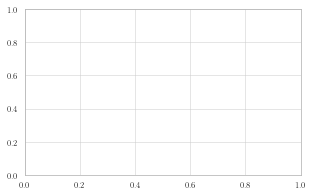

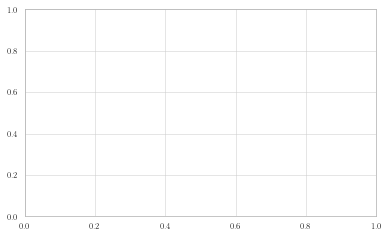

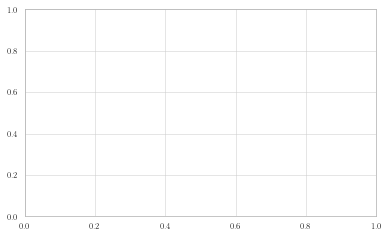

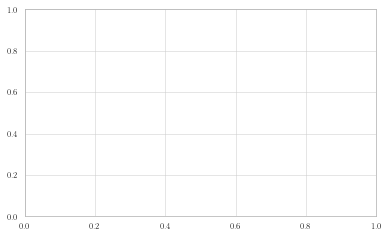

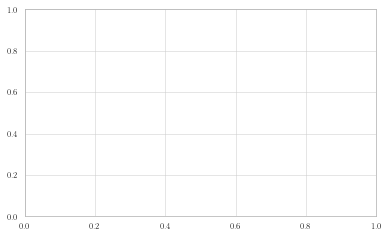

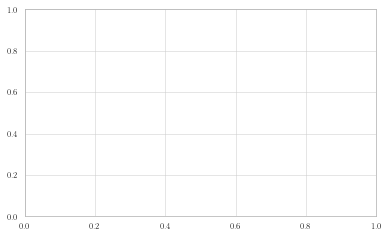

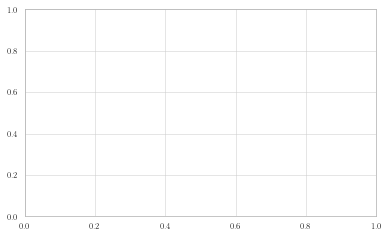

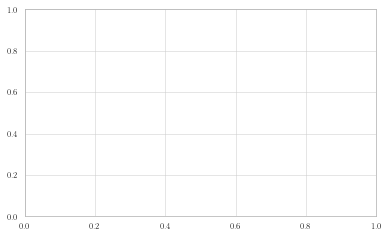

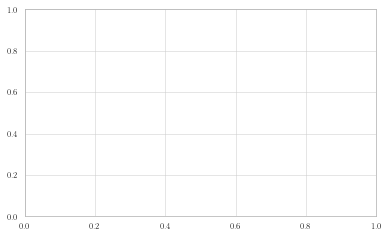

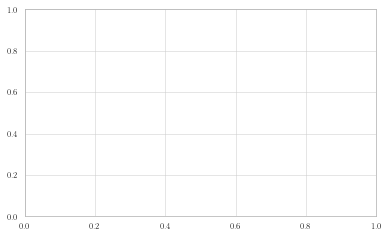

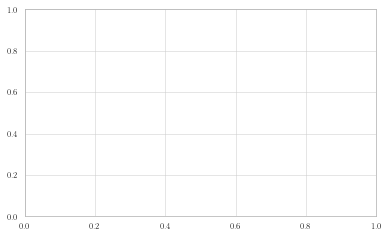

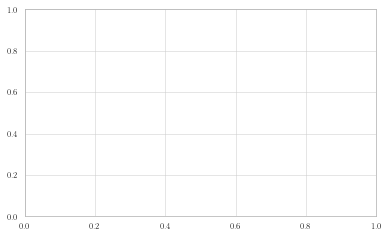

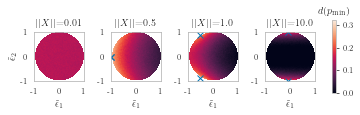

In [79]:
# Delta = Sigma
std_norms_combinations = {
    0.05: ([0.01, 0.025, 0.05, 10], [0.05]),
    0.1: ([0.01, 0.05, 0.1, 10], [0.1]),
    0.2: ([0.01, 0.1, 0.2, 10], [0.2]),
    0.25: ([0.01, 0.125, 0.25, 10], [0.25]),
    0.5: ([0.01, 0.25, 0.5, 10], [0.5]),
    1.0: ([0.01, 0.5, 1.0, 10], [1.0]),
}

base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump'
sub_dir = 'varying_norm_clean'
dump_dir = os.path.join(base_dir, sub_dir)

dump_varying_norm(results, dump_dir, std_norms_combinations, highlight_rotation=True, format='png')



base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/final'
sub_dir = 'varying_norm_clean'
dump_dir = os.path.join(base_dir, sub_dir)

dump_varying_norm(results, dump_dir, std_norms_combinations, highlight_rotation=True)


/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolorm

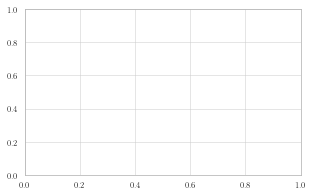

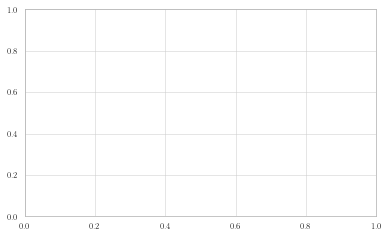

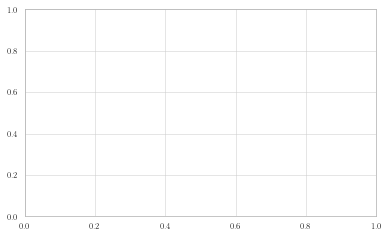

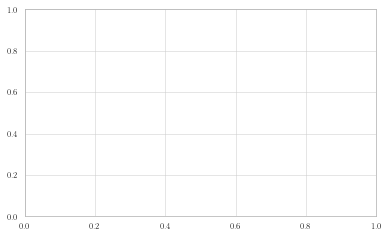

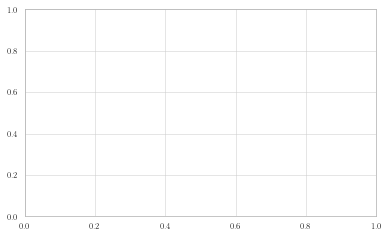

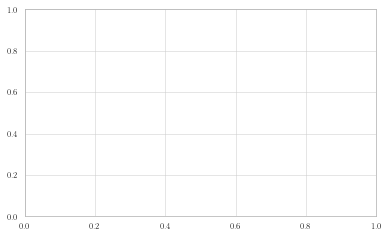

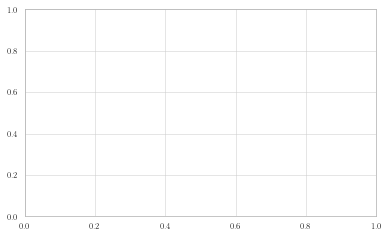

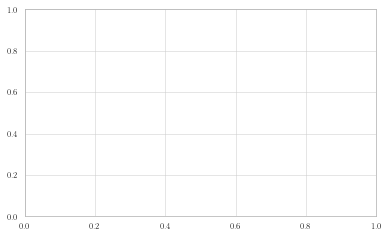

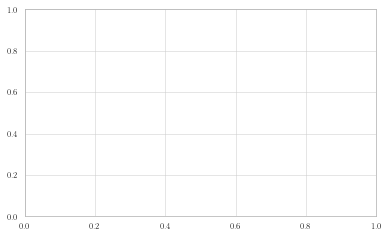

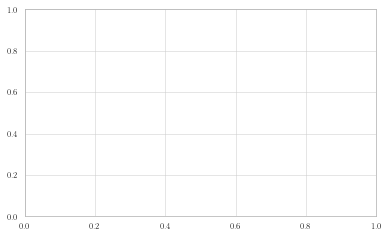

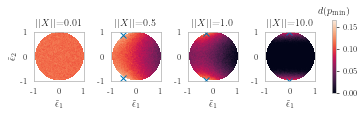

In [80]:
# Delta = Sigma / 2
std_norms_combinations = {
    #0.05: ([0.01, 0.025, 0.05, 10], [0.025]),
    0.1: ([0.01, 0.05, 0.1, 10], [0.05]),
    0.2: ([0.01, 0.1, 0.2, 10], [0.1]),
    0.25: ([0.01, 0.125, 0.25, 10], [0.125]),
    0.5: ([0.01, 0.25, 0.5, 10], [0.25]),
    1.0: ([0.01, 0.5, 1.0, 10], [0.5]),
}

base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump'
sub_dir = 'varying_norm_clean'
dump_dir = os.path.join(base_dir, sub_dir)

dump_varying_norm(results, dump_dir, std_norms_combinations, highlight_rotation=True, format='png')



base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/final'
sub_dir = 'varying_norm_clean'
dump_dir = os.path.join(base_dir, sub_dir)

dump_varying_norm(results, dump_dir, std_norms_combinations, highlight_rotation=True)


/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolorm

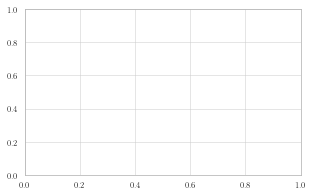

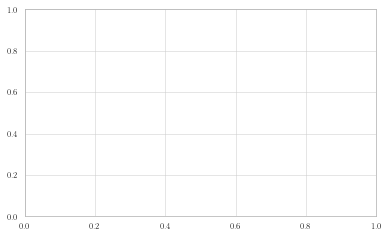

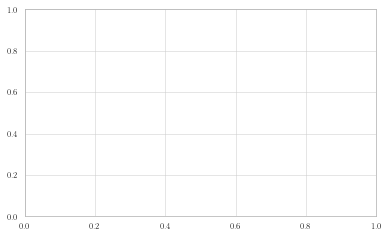

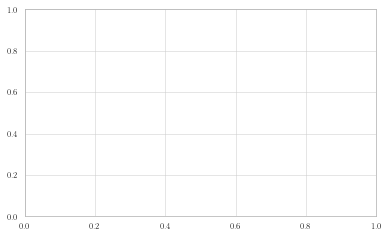

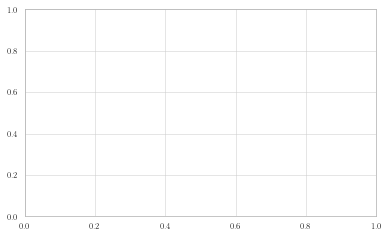

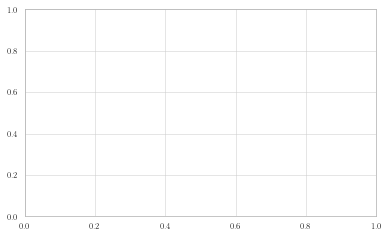

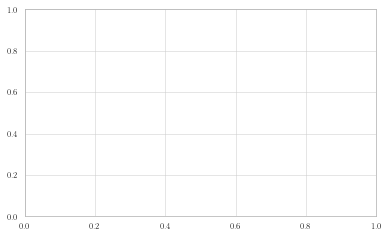

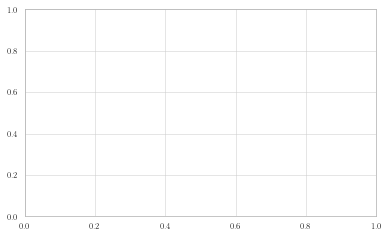

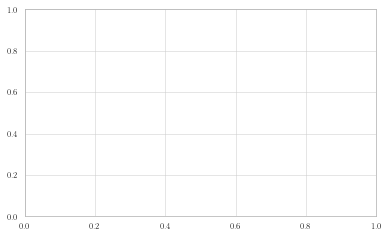

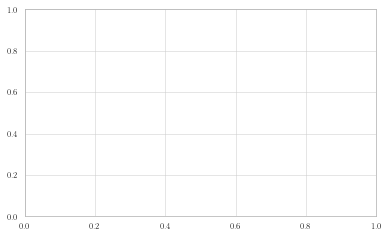

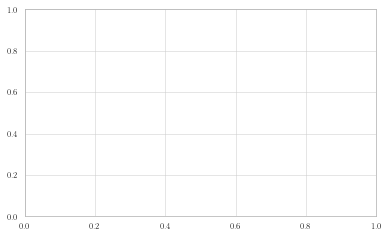

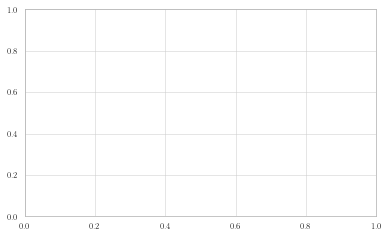

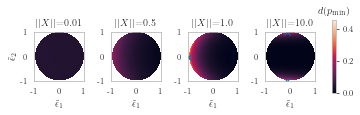

In [81]:
# Delta = 2 * sigma
std_norms_combinations = {
    0.05: ([0.01, 0.025, 0.05, 10], [0.1]),
    0.1: ([0.01, 0.05, 0.1, 10], [0.2]),
    0.2: ([0.01, 0.1, 0.2, 10], [0.4]),
    0.25: ([0.01, 0.125, 0.25, 10], [0.5]),
    0.5: ([0.01, 0.25, 0.5, 10], [1.0]),
    1.0: ([0.01, 0.5, 1.0, 10], [2.0]),
}

base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump'
sub_dir = 'varying_norm_clean'
dump_dir = os.path.join(base_dir, sub_dir)

dump_varying_norm(results, dump_dir, std_norms_combinations, highlight_rotation=True, format='png')



base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/final'
sub_dir = 'varying_norm_clean'
dump_dir = os.path.join(base_dir, sub_dir)

dump_varying_norm(results, dump_dir, std_norms_combinations, highlight_rotation=True)


/tmp/ipykernel_2017584/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_2017584/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_2017584/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_2017584/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolorm

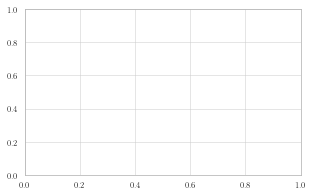

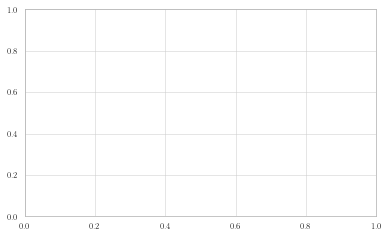

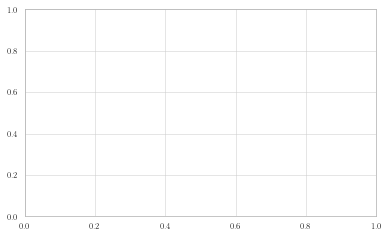

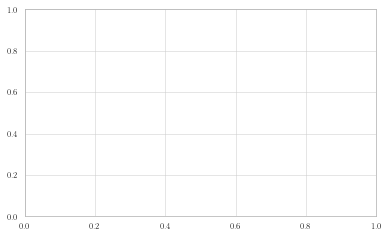

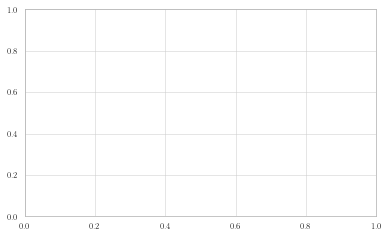

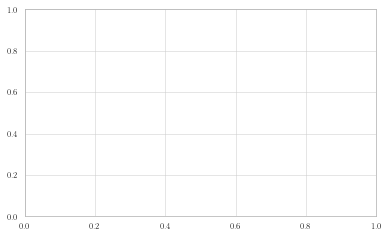

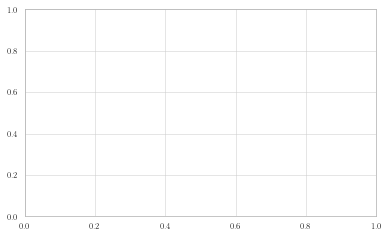

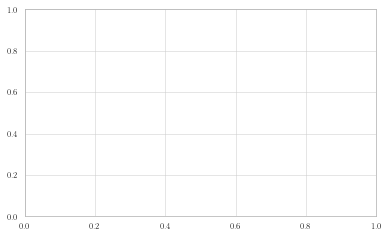

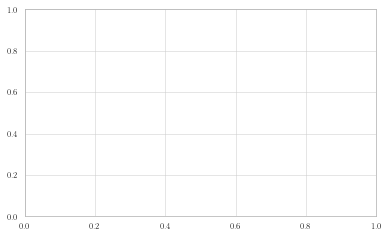

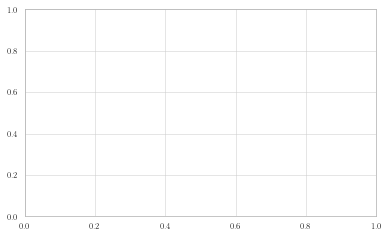

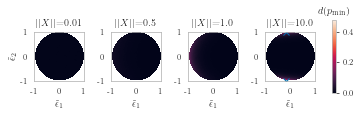

In [39]:
# Appendix plot 1: std = 1. delta = sigma/4, sigma/2, sigma, 2sigma, 3sigma. For each delta: choose norm_clean = 0.01, sigma/2, sigma, 10
params = [
    {1.0: ([0.01, 0.5, 1.0, 10], [0.25])},
    {1.0: ([0.01, 0.5, 1.0, 10], [0.5])},
    {1.0: ([0.01, 0.5, 1.0, 10], [1.0])},
    {1.0: ([0.01, 0.5, 1.0, 10], [2.0])},
    {1.0: ([0.01, 0.5, 1.0, 10], [3.0])},
]

for std_norms_combinations in params:

    base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump'
    sub_dir = 'varying_norm_clean'
    dump_dir = os.path.join(base_dir, sub_dir)

    dump_varying_norm(results, dump_dir, std_norms_combinations, highlight_rotation=True, format='png')



    base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/final'
    sub_dir = 'varying_norm_clean'
    dump_dir = os.path.join(base_dir, sub_dir)

    dump_varying_norm(results, dump_dir, std_norms_combinations, highlight_rotation=True)


/tmp/ipykernel_2017584/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_2017584/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_2017584/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_2017584/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolorm

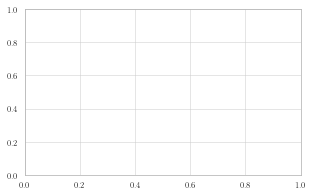

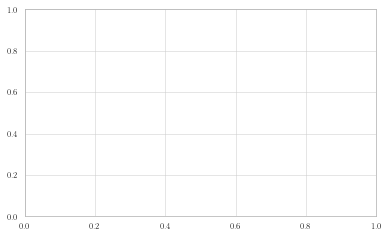

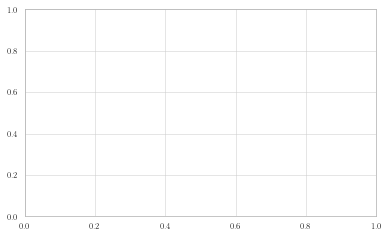

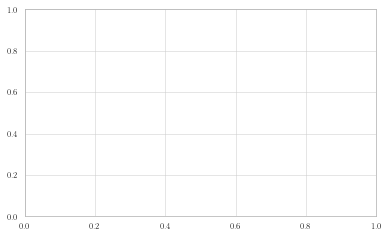

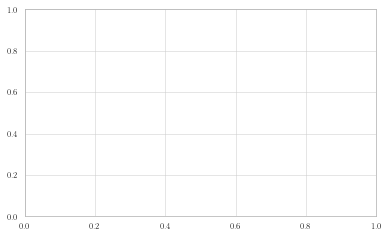

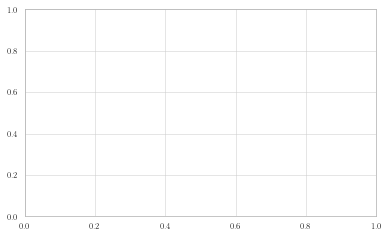

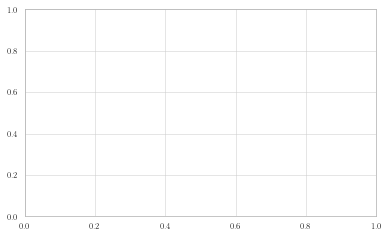

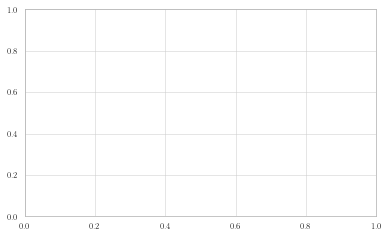

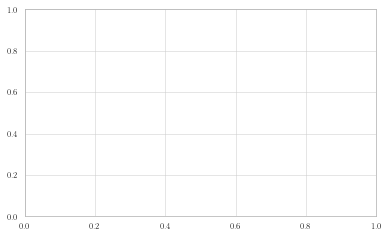

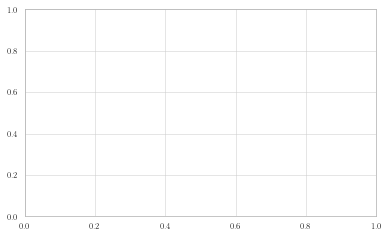

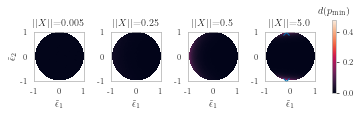

In [40]:
# Appendix plot 1: std = 1. delta = sigma/4, sigma/2, sigma, 2sigma, 3sigma. For each delta: choose norm_clean = 0.01, sigma/2, sigma, 10
params = [
    {0.5: ([0.005, 0.25, 0.5, 5], [0.125])},
    {0.5: ([0.005, 0.25, 0.5, 5], [0.25])},
    {0.5: ([0.005, 0.25, 0.5, 5], [0.5])},
    {0.5: ([0.005, 0.25, 0.5, 5], [1.0])},
    {0.5: ([0.005, 0.25, 0.5, 5], [1.5])},
]

for std_norms_combinations in params:

    base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump'
    sub_dir = 'varying_norm_clean'
    dump_dir = os.path.join(base_dir, sub_dir)

    dump_varying_norm(results, dump_dir, std_norms_combinations, highlight_rotation=True, format='png')



    base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/final'
    sub_dir = 'varying_norm_clean'
    dump_dir = os.path.join(base_dir, sub_dir)

    dump_varying_norm(results, dump_dir, std_norms_combinations, highlight_rotation=True)


In [33]:
# Dump rotation

/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump/varying_norm_delta/0.05


/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)


/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump/varying_norm_delta/0.1


/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)


/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump/varying_norm_delta/0.15


/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)


/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump/varying_norm_delta/0.2


/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)


/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump/varying_norm_delta/0.25


/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)


/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump/varying_norm_delta/0.5


/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)


/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump/varying_norm_delta/1.0


/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolorm

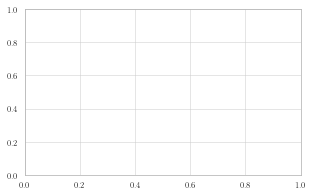

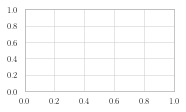

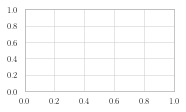

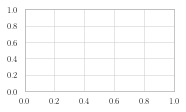

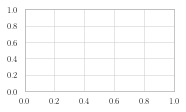

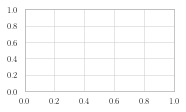

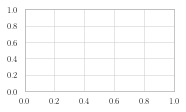

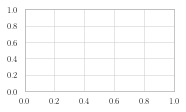

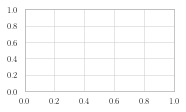

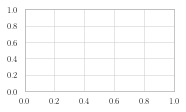

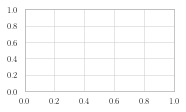

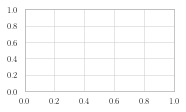

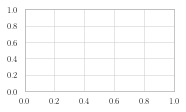

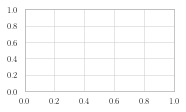

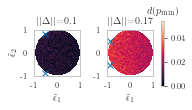

In [87]:
# Norm-clean = 0.1
std_norms_combinations = {
    0.05: ([0.1], [0.1, 0.17]),
    0.1: ([0.1], [0.1, 0.17]),
    0.15: ([0.1], [0.1, 0.17]),
    0.2: ([0.1], [0.1, 0.17]),
    0.25: ([0.1], [0.1, 0.17]),
    0.5: ([0.1], [0.1, 0.17]),
    1.0:([0.1], [0.1, 0.17]),
}

base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump'
sub_dir = 'varying_norm_delta'
dump_dir = os.path.join(base_dir, sub_dir)

dump_varying_norm(results, dump_dir, std_norms_combinations,
                  highlight_rotation=True, width=0.49, shrink_colorbar=0.8, format='png')

base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/final'
sub_dir = 'varying_norm_delta'
dump_dir = os.path.join(base_dir, sub_dir)

dump_varying_norm(results, dump_dir, std_norms_combinations,
                  highlight_rotation=True, width=0.49, shrink_colorbar=0.8, format='pdf')

/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolorm

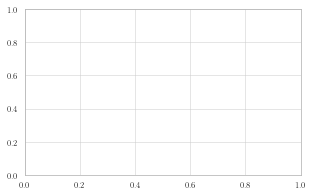

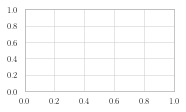

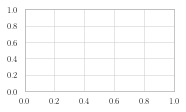

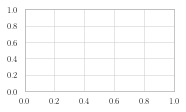

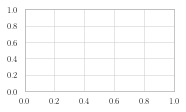

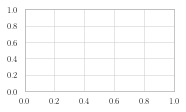

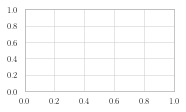

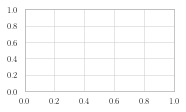

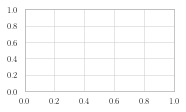

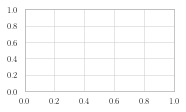

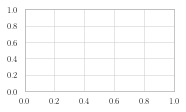

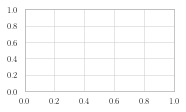

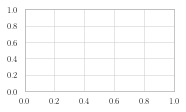

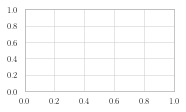

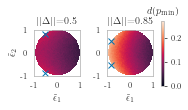

In [88]:
# Norm-clean = 0.5
std_norms_combinations = {
    0.05: ([0.5], [0.5, 0.85]),
    0.1: ([0.5], [0.5, 0.85]),
    0.15: ([0.5], [0.5, 0.85]),
    0.2: ([0.5], [0.5, 0.85]),
    0.25: ([0.5], [0.5, 0.85]),
    0.5: ([0.5], [0.5, 0.85]),
    1.0: ([0.5], [0.5, 0.85]),
}

base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump'
sub_dir = 'varying_norm_delta'
dump_dir = os.path.join(base_dir, sub_dir)

dump_varying_norm(results, dump_dir, std_norms_combinations,
                  highlight_rotation=True, width=0.49, shrink_colorbar=0.8, format='png')

base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/final'
sub_dir = 'varying_norm_delta'
dump_dir = os.path.join(base_dir, sub_dir)

dump_varying_norm(results, dump_dir, std_norms_combinations,
                  highlight_rotation=True, width=0.49, shrink_colorbar=0.8, format='pdf')


/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolorm

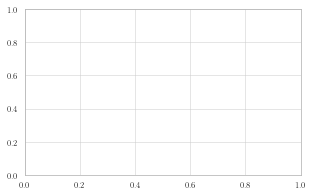

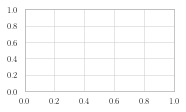

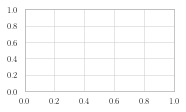

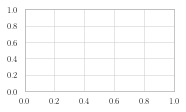

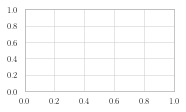

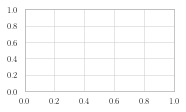

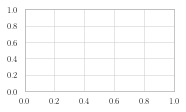

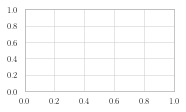

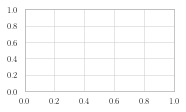

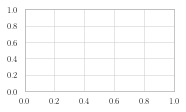

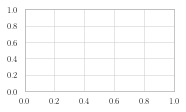

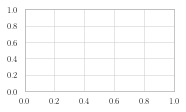

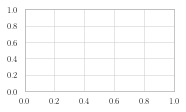

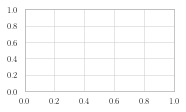

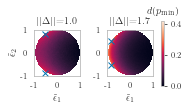

In [89]:
# Norm-clean = 1
std_norms_combinations = {
    0.05: ([1.0], [1, 1.7]),
    0.1: ([1.0], [1, 1.7]),
    0.15: ([1.0], [1, 1.7]),
    0.2: ([1.0], [1, 1.7]),
    0.25: ([1.0], [1, 1.7]),
    0.5: ([1.0], [1, 1.7]),
    1.0: ([1.0], [1, 1.7])
}

base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump'
sub_dir = 'varying_norm_delta'
dump_dir = os.path.join(base_dir, sub_dir)

dump_varying_norm(results, dump_dir, std_norms_combinations,
                  highlight_rotation=True, width=0.49, shrink_colorbar=0.8, format='png')

base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/final'
sub_dir = 'varying_norm_delta'
dump_dir = os.path.join(base_dir, sub_dir)

dump_varying_norm(results, dump_dir, std_norms_combinations,
                  highlight_rotation=True, width=0.49, shrink_colorbar=0.8, format='pdf')


/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolorm

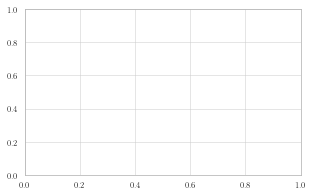

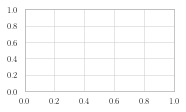

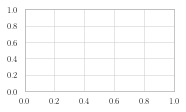

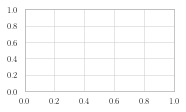

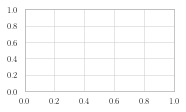

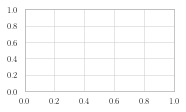

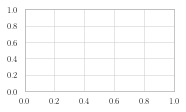

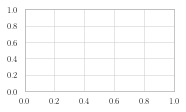

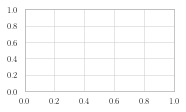

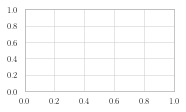

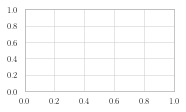

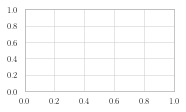

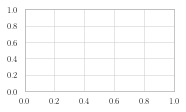

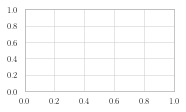

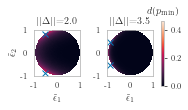

In [90]:
# Norm-clean = 2
std_norms_combinations = {
    0.05: ([2.0], [2.0, 3.5]),
    0.1: ([2.0], [2.0, 3.5]),
    0.15: ([2.0], [2.0, 3.5]),
    0.2: ([2.0], [2.0, 3.5]),
    0.25: ([2.0], [2.0, 3.5]),
    0.5: ([2.0], [2.0, 3.5]),
    1.0: ([2.0], [2.0, 3.5]),
}

base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump'
sub_dir = 'varying_norm_delta'
dump_dir = os.path.join(base_dir, sub_dir)

dump_varying_norm(results, dump_dir, std_norms_combinations,
                  highlight_rotation=True, width=0.49, shrink_colorbar=0.8, format='png')

base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/final'
sub_dir = 'varying_norm_delta'
dump_dir = os.path.join(base_dir, sub_dir)

dump_varying_norm(results, dump_dir, std_norms_combinations,
                  highlight_rotation=True, width=0.49, shrink_colorbar=0.8, format='pdf')

/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)
/tmp/ipykernel_1172404/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolorm

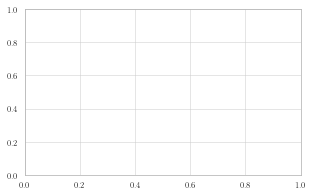

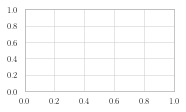

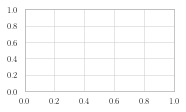

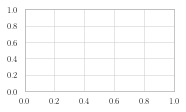

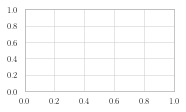

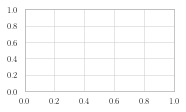

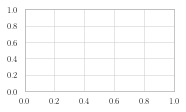

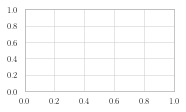

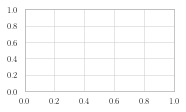

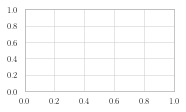

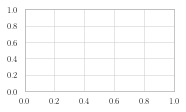

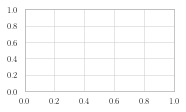

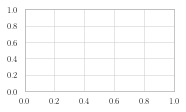

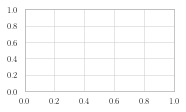

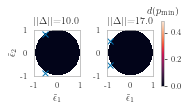

In [91]:
# Norm-clean = 10
std_norms_combinations = {
    0.05: ([10.0], [10.0, 17]),
    0.1: ([10.0], [10.0, 17]),
    0.15: ([10.0], [10.0, 17]),
    0.2: ([10.0], [10.0, 17]),
    0.25: ([10.0], [10.0, 17]),
    0.5: ([10.0], [10.0, 17]),
    1.0: ([10.0], [10.0, 17]),
}

base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/dump'
sub_dir = 'varying_norm_delta'
dump_dir = os.path.join(base_dir, sub_dir)

dump_varying_norm(results, dump_dir, std_norms_combinations,
                  highlight_rotation=True, width=0.49, shrink_colorbar=0.8, format='png')

base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips/inverse/multiple_inner_cross/final'
sub_dir = 'varying_norm_delta'
dump_dir = os.path.join(base_dir, sub_dir)

dump_varying_norm(results, dump_dir, std_norms_combinations,
                  highlight_rotation=True, width=0.49, shrink_colorbar=0.8, format='pdf')

/tmp/ipykernel_3026132/3230840805.py:59: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)


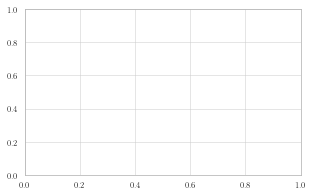

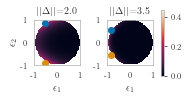

In [107]:
plot_multiple_colormaps(results, 1.0, [2.0], [2.0, 3.5],
                            shared_colorbar=True, highlight_maximum=True, width=0.49, shrink_colorbar=0.8)

/tmp/ipykernel_2017584/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)


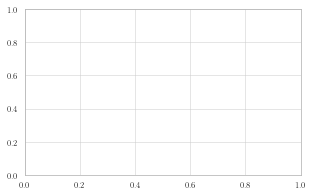

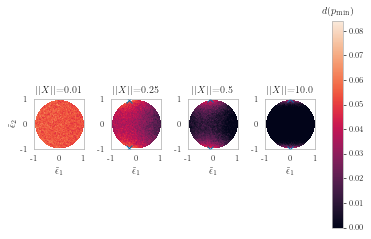

In [20]:
std = 0.5
deltas = [0.125]
norms_clean = [0.01, 0.25, 0.5, 10]

plot_multiple_colormaps(results, std, norms_clean, deltas,
                        shared_colorbar=True, highlight_rotation=True, width=1, shrink_colorbar=1)

/tmp/ipykernel_2017584/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)


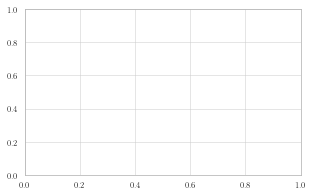

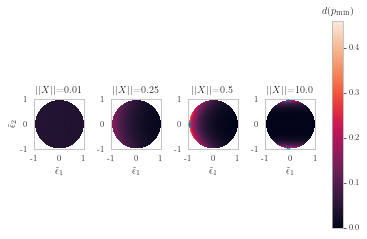

In [13]:
std = 0.5
deltas = [1]
norms_clean = [0.01, 0.25, 0.5, 10]

plot_multiple_colormaps(results, std, norms_clean, deltas,
                        shared_colorbar=True, highlight_rotation=True, width=1, shrink_colorbar=1)

/tmp/ipykernel_2017584/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)


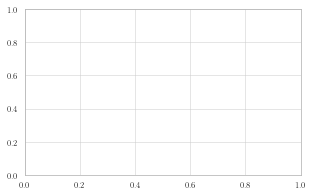

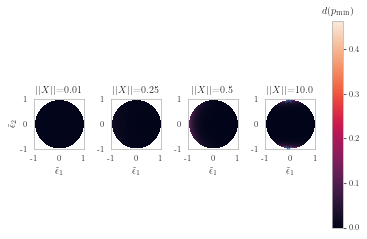

In [14]:
std = 0.5
deltas = [1.5]
norms_clean = [0.01, 0.25, 0.5, 10]

plot_multiple_colormaps(results, std, norms_clean, deltas,
                        shared_colorbar=True, highlight_rotation=True, width=1, shrink_colorbar=1)

/tmp/ipykernel_2017584/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)


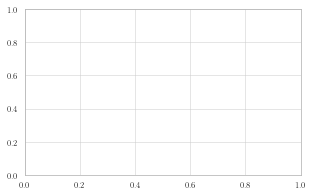

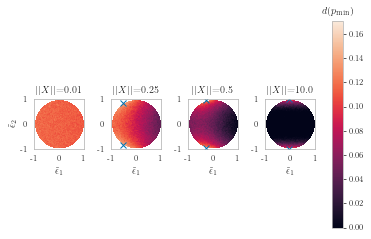

In [15]:
std = 0.5
deltas = [0.25]
norms_clean = [0.01, 0.25, 0.5, 10]

plot_multiple_colormaps(results, std, norms_clean, deltas,
                        shared_colorbar=True, highlight_rotation=True, width=1, shrink_colorbar=1)

/tmp/ipykernel_2017584/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)


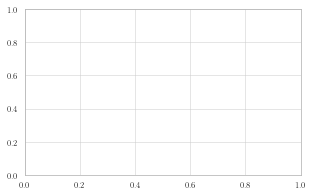

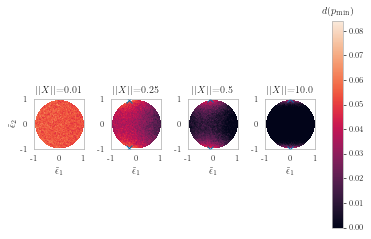

In [16]:
std = 0.5
deltas = [0.125]
norms_clean = [0.01, 0.25, 0.5, 10]

plot_multiple_colormaps(results, std, norms_clean, deltas,
                        shared_colorbar=True, highlight_rotation=True, width=1, shrink_colorbar=1)

/tmp/ipykernel_2017584/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)


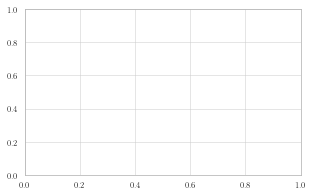

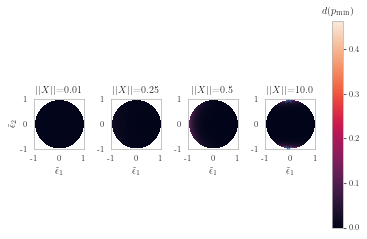

In [18]:
std = 0.5
deltas = [1.5]
norms_clean = [0.01, 0.25, 0.5, 10]

plot_multiple_colormaps(results, std, norms_clean, deltas,
                        shared_colorbar=True, highlight_rotation=True, width=1, shrink_colorbar=1)

/tmp/ipykernel_2017584/226842642.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=shrink_colorbar)


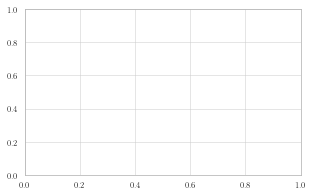

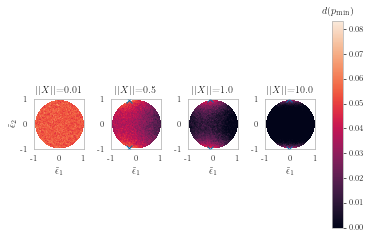

In [24]:
std = 1
deltas = [0.25]
norms_clean = [0.01, 0.5, 1.0, 10]

plot_multiple_colormaps(results, std, norms_clean, deltas,
                        shared_colorbar=True, highlight_rotation=True, width=1, shrink_colorbar=1)